In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer,DistilBertForSequenceClassification, AdamW
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary 
from torchviz import make_dot

2024-04-21 17:13:00.110004: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-21 17:13:00.174701: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 17:13:01.312077: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Télécharger les données

In [2]:
data_frame=pd.read_csv("/home/onyxia/work/NLP_3A_ENSAE/data_bases/data_cleaned.csv",sep=",")

In [3]:
data_frame.head()

,Unnamed: 0,sex,first_name,surname
0,0,femme,Marie,Chardon
1,1,homme,Louis,Lhopital
2,2,femme,Marie,Pyrin
3,3,femme,Marie,Lavocat
4,4,femme,Marguerite,Benne


In [4]:
texts = data_frame['first_name'].tolist()
labels = data_frame['sex'].tolist()


# Télécharger le modèle de Hagging face et manipulation des données pour le fine tuning

In [2]:
model_name = "padmajabfrl/Gender-Classification"
tokenizer = AutoTokenizer.from_pretrained(model_name)
#model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [3]:
tokenizer

DistilBertTokenizerFast(name_or_path='padmajabfrl/Gender-Classification', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

## Je split les données en training et testing

In [6]:

train_texts, test_texts, train_labels,test_labels = train_test_split(texts, labels, test_size=.2)



In [7]:
# Je transforme mes données de façon à ce que les femmes soient encodées en 1 et les hommes en 0
label_map = {'homme': 0, 'femme': 1}  
train_labels = [label_map[label] for label in train_labels]
test_labels = [label_map[label] for label in test_labels]

Turn the data to Dataset

In [8]:
class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label)
        }

    def __len__(self):
        return len(self.labels)


train_dataset = IMDbDataset(train_texts, train_labels, tokenizer, max_length=128)
test_dataset = IMDbDataset(test_texts, test_labels, tokenizer, max_length=128)


In [13]:
class GenderClassifier:
    def __init__(self, model_name='padmajabfrl/Gender-Classification'):
        self.model = DistilBertForSequenceClassification.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.accuracy=0
        self.recall_acc=0

    def train(self, train_dataset, num_epochs=10, batch_size=16, learning_rate=5e-5):
        self.model.to(self.device)
        self.model.train()
        optimizer = torch.optim.AdamW (self.model.parameters(), lr=learning_rate)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(num_epochs):
            total_loss = 0
            for batch in train_loader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                optimizer.zero_grad()
                outputs = self.model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            average_loss = total_loss / len(train_loader)
            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}')

        self.model.eval()

    def predict(self, input_text):
        inputs = self.tokenizer(input_text, return_tensors='pt')
        inputs = {key: val.to(self.device) for key, val in inputs.items()}

        with torch.no_grad():
            outputs = self.model(**inputs)

        predictions = torch.argmax(outputs.logits, dim=1).item()
        label_map = {0: 'homme', 1: 'femme'}
        predicted_label = label_map[predictions]

        return predicted_label
    
    def evaluate(self,test_dataset, batch_size=16,conf_matrix=False,Roc_curve=False,pr_curve=False):
        self.model.eval()
        all_probs = []
        true_labels = []
        predicted_labels = []
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
        for batch in test_loader:
            input_ids = batch['input_ids'].to(classifier.device)
            attention_mask = batch['attention_mask'].to(classifier.device)
            labels = batch['labels']

            with torch.no_grad():
                outputs = classifier.model(input_ids, attention_mask=attention_mask)

            predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()


            # Metrics calculation for visualization
            if Roc_curve or pr_curve:
                probs = torch.softmax(outputs.logits, dim=1)
                all_probs.extend(probs[:, 1].cpu().numpy())
                


            true_labels.extend(labels)
            predicted_labels.extend(predictions)
        true_labels = np.array(true_labels)

        predicted_labels = np.array(predicted_labels)
        accuracy = accuracy_score(true_labels, predicted_labels)
        self.accuracy=accuracy
        report = classification_report(true_labels, predicted_labels)
        print(f"The model's accuracy on the testing dataset is: {accuracy}. \n The model's performance report on the testing dataset is the following :\n {report}")

        # Plotting some intersting metrics about the classifier

        #Confucion matrix

        if conf_matrix:
          print("Find bellow the Confusion Matrix")
          conf_matrix = confusion_matrix(true_labels, predicted_labels)
          sns.heatmap(conf_matrix, fmt='d', cmap='BuPu', annot=True)
          plt.imshow(conf_matrix, cmap='BuPu', interpolation='nearest')
          plt.title('Confusion Matrix')
          plt.xlabel('Predicted Label')
          plt.ylabel('True Label')
          plt.xticks([0, 1], ['homme', 'femme'])
          plt.yticks([0, 1], ['homme', 'femme'])
          plt.show()

        
        #ROC Curve

        if Roc_curve:
            print("Find bellow the ROC Curve")
            fpr, tpr, _ = roc_curve(true_labels, all_probs)
            roc_auc = auc(fpr, tpr)

            plt.figure()
            plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC) Curve')
            plt.legend(loc="lower right")
            plt.show()

        
        #Precision-Recall Curve

        if pr_curve:
            print("Find bellow the Precision-Recall Curve")
            precision, recall, _ = precision_recall_curve(true_labels, all_probs)
            pr_auc = auc(recall, precision)
            self.recall_acc=pr_auc
            plt.figure()
            plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title('Precision-Recall Curve')
            plt.legend(loc="lower left")
            plt.show()
    
    def visualize_model(self):
        '''
        Afin d'utiliser cette méthode assurez vous que vous avez installé la bibliothéque 
        graphviz. Une manière de faire est d'executer ces commandes depuis votre terminal:
        sudo add-apt-repository universe
        sudo apt update
        sudo apt install graphviz
        '''

        self.model.to(self.device)
        
        inputs = self.tokenizer("Ilyes Hammouda", return_tensors="pt", padding=True, truncation=True)
        # Move inputs to the same device as the model
        inputs = {key: val.to(self.device) for key, val in inputs.items()}
        outputs = self.model(**inputs)
        dot = make_dot(outputs.logits, params=dict(classifier.model.named_parameters()))
        # Enregistrer la figure 
        dot.render("model_visualization", format="png")


In [16]:
# Training
classifier = GenderClassifier()
classifier.train(train_dataset,num_epochs=20)  

Epoch 1/20, Loss: 0.3733
Epoch 2/20, Loss: 0.1546
Epoch 3/20, Loss: 0.1387
Epoch 4/20, Loss: 0.1137
Epoch 5/20, Loss: 0.0593
Epoch 6/20, Loss: 0.0529
Epoch 7/20, Loss: 0.0400
Epoch 8/20, Loss: 0.0275
Epoch 9/20, Loss: 0.0485
Epoch 10/20, Loss: 0.0270
Epoch 11/20, Loss: 0.0270
Epoch 12/20, Loss: 0.0251
Epoch 13/20, Loss: 0.0207
Epoch 14/20, Loss: 0.0226
Epoch 15/20, Loss: 0.0228
Epoch 16/20, Loss: 0.0220
Epoch 17/20, Loss: 0.0236
Epoch 18/20, Loss: 0.0229
Epoch 19/20, Loss: 0.0212
Epoch 20/20, Loss: 0.0224


In [18]:
# Générer une figure descreptive du modèle
classifier.visualize_model()

In [13]:
# Exemple de Prediction
prediction = classifier.predict("Francoise")
print(f'Predicted label: {prediction}')

Predicted label: femme


The model's accuracy on the testing dataset is: 0.9361702127659575. 
 The model's performance report on the testing dataset is the following :
               precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           1       0.93      0.96      0.94        26

    accuracy                           0.94        47
   macro avg       0.94      0.93      0.94        47
weighted avg       0.94      0.94      0.94        47

Find bellow the Confusion Matrix


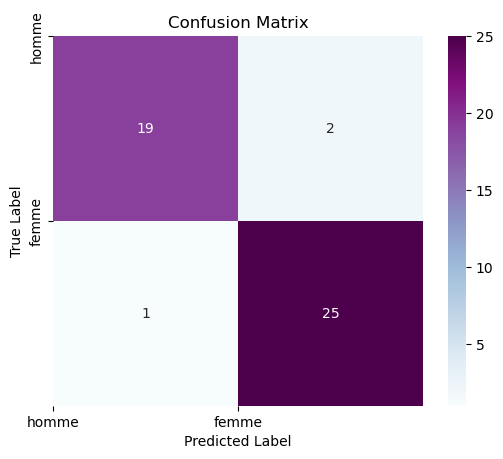

Find bellow the ROC Curve


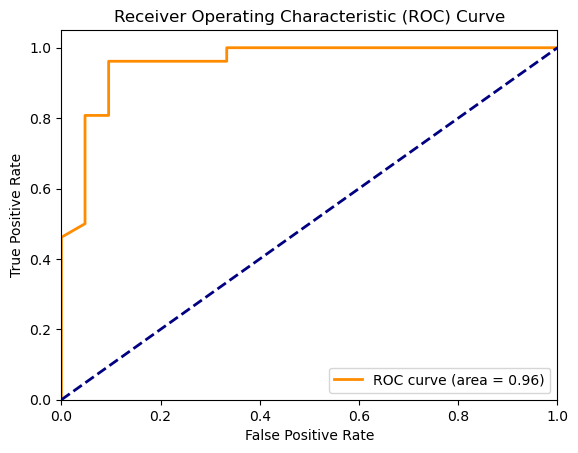

Find bellow the Precision-Recall Curve


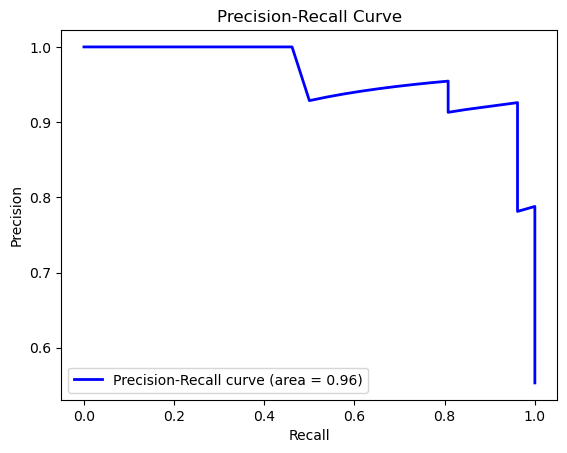

In [ ]:
#Exemple de prédiction 
classifier.evaluate(test_dataset,conf_matrix=True,Roc_curve=True,pr_curve=True)

# Tester la stabilité du modèle

Epoch 1/15, Loss: 0.4639
Epoch 2/15, Loss: 0.2390
Epoch 3/15, Loss: 0.1166
Epoch 4/15, Loss: 0.0923
Epoch 5/15, Loss: 0.0798
Epoch 6/15, Loss: 0.0665
Epoch 7/15, Loss: 0.0669
Epoch 8/15, Loss: 0.0564
Epoch 9/15, Loss: 0.0640
Epoch 10/15, Loss: 0.0554
Epoch 11/15, Loss: 0.0612
Epoch 12/15, Loss: 0.0474
Epoch 13/15, Loss: 0.2786
Epoch 14/15, Loss: 0.0724
Epoch 15/15, Loss: 0.0835
The model's accuracy on the testing dataset is: 0.9571428571428572. 
 The model's performance report on the testing dataset is the following :
               precision    recall  f1-score   support

           0       1.00      0.93      0.96        42
           1       0.90      1.00      0.95        28

    accuracy                           0.96        70
   macro avg       0.95      0.96      0.96        70
weighted avg       0.96      0.96      0.96        70

Find bellow the Precision-Recall Curve


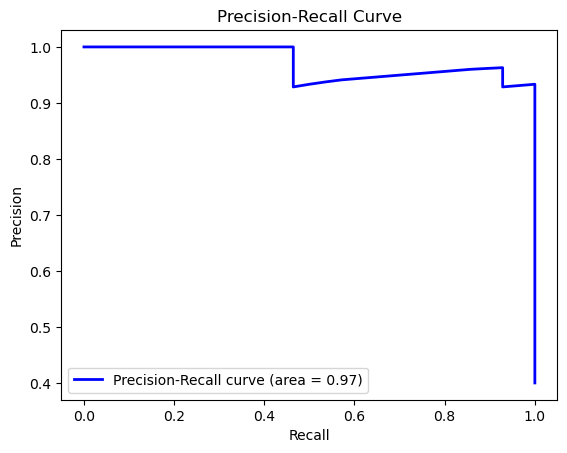

Epoch 1/15, Loss: 0.4307
Epoch 2/15, Loss: 0.1148
Epoch 3/15, Loss: 0.0625
Epoch 4/15, Loss: 0.0395
Epoch 5/15, Loss: 0.0206
Epoch 6/15, Loss: 0.0079
Epoch 7/15, Loss: 0.0049
Epoch 8/15, Loss: 0.0009
Epoch 9/15, Loss: 0.0021
Epoch 10/15, Loss: 0.0008
Epoch 11/15, Loss: 0.0077
Epoch 12/15, Loss: 0.0103
Epoch 13/15, Loss: 0.0007
Epoch 14/15, Loss: 0.0012
Epoch 15/15, Loss: 0.0001
The model's accuracy on the testing dataset is: 0.8714285714285714. 
 The model's performance report on the testing dataset is the following :
               precision    recall  f1-score   support

           0       0.90      0.88      0.89        42
           1       0.83      0.86      0.84        28

    accuracy                           0.87        70
   macro avg       0.87      0.87      0.87        70
weighted avg       0.87      0.87      0.87        70

Find bellow the Precision-Recall Curve


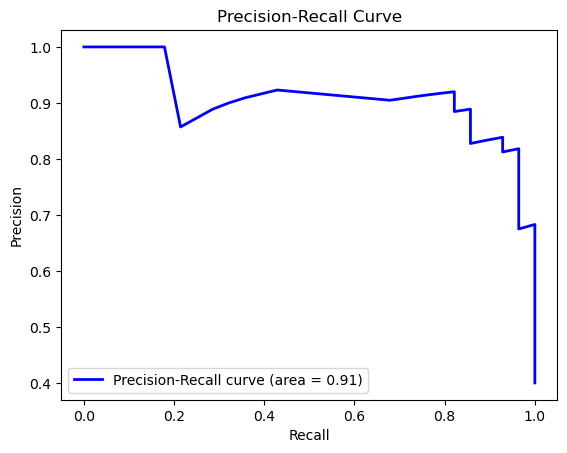

Epoch 1/15, Loss: 0.8599
Epoch 2/15, Loss: 0.2152
Epoch 3/15, Loss: 0.1112
Epoch 4/15, Loss: 0.0763
Epoch 5/15, Loss: 0.0403
Epoch 6/15, Loss: 0.0371
Epoch 7/15, Loss: 0.0344
Epoch 8/15, Loss: 0.0310
Epoch 9/15, Loss: 0.0309
Epoch 10/15, Loss: 0.0266
Epoch 11/15, Loss: 0.0249
Epoch 12/15, Loss: 0.0279
Epoch 13/15, Loss: 0.0279
Epoch 14/15, Loss: 0.0243
Epoch 15/15, Loss: 0.0266
The model's accuracy on the testing dataset is: 0.9. 
 The model's performance report on the testing dataset is the following :
               precision    recall  f1-score   support

           0       0.97      0.85      0.91        40
           1       0.83      0.97      0.89        30

    accuracy                           0.90        70
   macro avg       0.90      0.91      0.90        70
weighted avg       0.91      0.90      0.90        70

Find bellow the Precision-Recall Curve


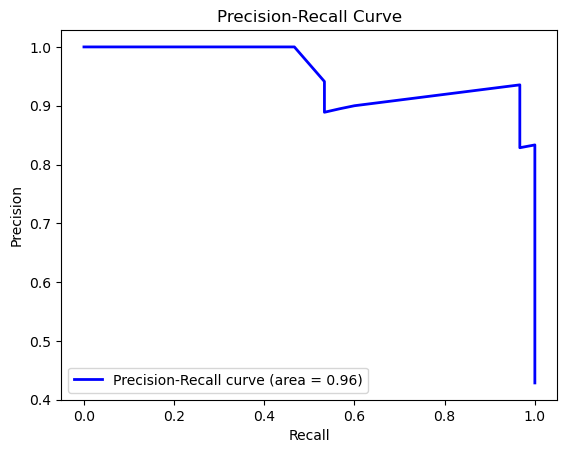

Epoch 1/15, Loss: 0.3815
Epoch 2/15, Loss: 0.1358
Epoch 3/15, Loss: 0.0775
Epoch 4/15, Loss: 0.0275
Epoch 5/15, Loss: 0.0092
Epoch 6/15, Loss: 0.0112
Epoch 7/15, Loss: 0.0019
Epoch 8/15, Loss: 0.0014
Epoch 9/15, Loss: 0.0019
Epoch 10/15, Loss: 0.0007
Epoch 11/15, Loss: 0.0011
Epoch 12/15, Loss: 0.0047
Epoch 13/15, Loss: 0.0227
Epoch 14/15, Loss: 0.0010
Epoch 15/15, Loss: 0.0050
The model's accuracy on the testing dataset is: 0.9. 
 The model's performance report on the testing dataset is the following :
               precision    recall  f1-score   support

           0       1.00      0.83      0.91        42
           1       0.80      1.00      0.89        28

    accuracy                           0.90        70
   macro avg       0.90      0.92      0.90        70
weighted avg       0.92      0.90      0.90        70

Find bellow the Precision-Recall Curve


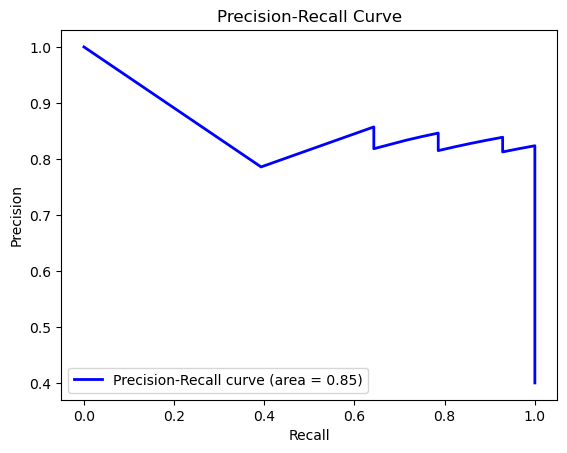

Epoch 1/15, Loss: 0.5349
Epoch 2/15, Loss: 0.1405
Epoch 3/15, Loss: 0.0817
Epoch 4/15, Loss: 0.0607
Epoch 5/15, Loss: 0.0854
Epoch 6/15, Loss: 0.0712
Epoch 7/15, Loss: 0.0489
Epoch 8/15, Loss: 0.0433
Epoch 9/15, Loss: 0.0421
Epoch 10/15, Loss: 0.0375
Epoch 11/15, Loss: 0.0363
Epoch 12/15, Loss: 0.0375
Epoch 13/15, Loss: 0.0338
Epoch 14/15, Loss: 0.0442
Epoch 15/15, Loss: 0.0410
The model's accuracy on the testing dataset is: 0.9714285714285714. 
 The model's performance report on the testing dataset is the following :
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        29
           1       1.00      0.95      0.97        41

    accuracy                           0.97        70
   macro avg       0.97      0.98      0.97        70
weighted avg       0.97      0.97      0.97        70

Find bellow the Precision-Recall Curve


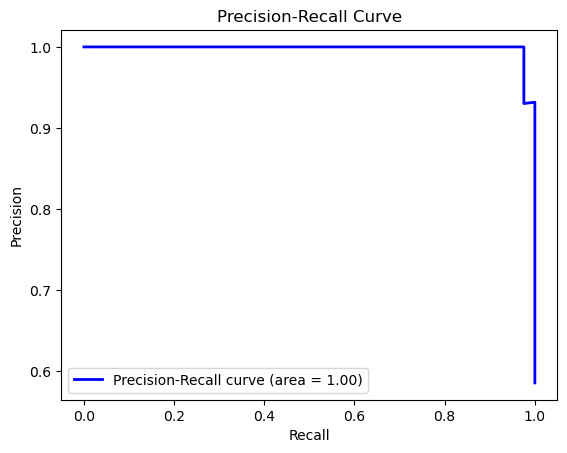

Epoch 1/15, Loss: 0.5915
Epoch 2/15, Loss: 0.1786
Epoch 3/15, Loss: 0.1314
Epoch 4/15, Loss: 0.0874
Epoch 5/15, Loss: 0.0879
Epoch 6/15, Loss: 0.0647
Epoch 7/15, Loss: 0.0649
Epoch 8/15, Loss: 0.0608
Epoch 9/15, Loss: 0.0517
Epoch 10/15, Loss: 0.0461
Epoch 11/15, Loss: 0.0425
Epoch 12/15, Loss: 0.0439
Epoch 13/15, Loss: 0.0468
Epoch 14/15, Loss: 0.0397
Epoch 15/15, Loss: 0.0395
The model's accuracy on the testing dataset is: 0.9571428571428572. 
 The model's performance report on the testing dataset is the following :
               precision    recall  f1-score   support

           0       0.97      0.94      0.96        36
           1       0.94      0.97      0.96        34

    accuracy                           0.96        70
   macro avg       0.96      0.96      0.96        70
weighted avg       0.96      0.96      0.96        70

Find bellow the Precision-Recall Curve


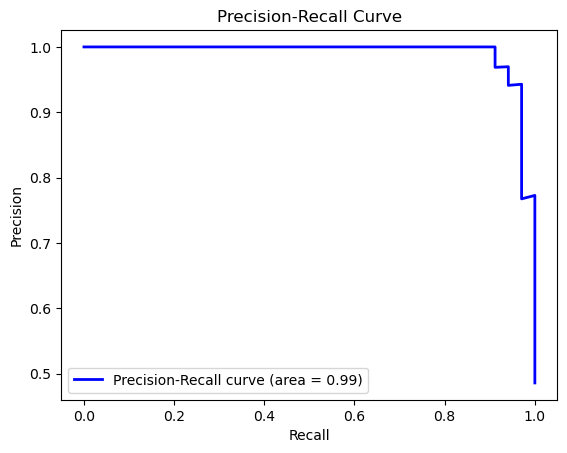

Epoch 1/15, Loss: 0.5572
Epoch 2/15, Loss: 0.1835
Epoch 3/15, Loss: 0.1091
Epoch 4/15, Loss: 0.0707
Epoch 5/15, Loss: 0.0504
Epoch 6/15, Loss: 0.0455
Epoch 7/15, Loss: 0.0375
Epoch 8/15, Loss: 0.0246
Epoch 9/15, Loss: 0.0303
Epoch 10/15, Loss: 0.0315
Epoch 11/15, Loss: 0.0261
Epoch 12/15, Loss: 0.0291
Epoch 13/15, Loss: 0.0220
Epoch 14/15, Loss: 0.0225
Epoch 15/15, Loss: 0.0223
The model's accuracy on the testing dataset is: 0.9571428571428572. 
 The model's performance report on the testing dataset is the following :
               precision    recall  f1-score   support

           0       0.97      0.94      0.95        32
           1       0.95      0.97      0.96        38

    accuracy                           0.96        70
   macro avg       0.96      0.96      0.96        70
weighted avg       0.96      0.96      0.96        70

Find bellow the Precision-Recall Curve


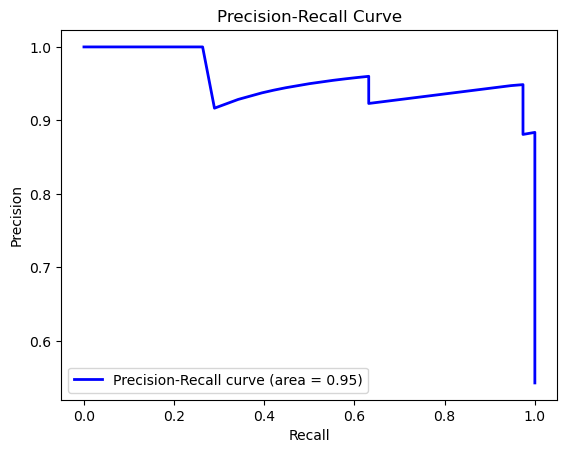

Epoch 1/15, Loss: 0.6268
Epoch 2/15, Loss: 0.1850
Epoch 3/15, Loss: 0.0799
Epoch 4/15, Loss: 0.0409
Epoch 5/15, Loss: 0.0252
Epoch 6/15, Loss: 0.0326
Epoch 7/15, Loss: 0.0314
Epoch 8/15, Loss: 0.0168
Epoch 9/15, Loss: 0.0141
Epoch 10/15, Loss: 0.0125
Epoch 11/15, Loss: 0.0131
Epoch 12/15, Loss: 0.0120
Epoch 13/15, Loss: 0.0119
Epoch 14/15, Loss: 0.0116
Epoch 15/15, Loss: 0.0107
The model's accuracy on the testing dataset is: 0.9428571428571428. 
 The model's performance report on the testing dataset is the following :
               precision    recall  f1-score   support

           0       1.00      0.91      0.95        43
           1       0.87      1.00      0.93        27

    accuracy                           0.94        70
   macro avg       0.94      0.95      0.94        70
weighted avg       0.95      0.94      0.94        70

Find bellow the Precision-Recall Curve


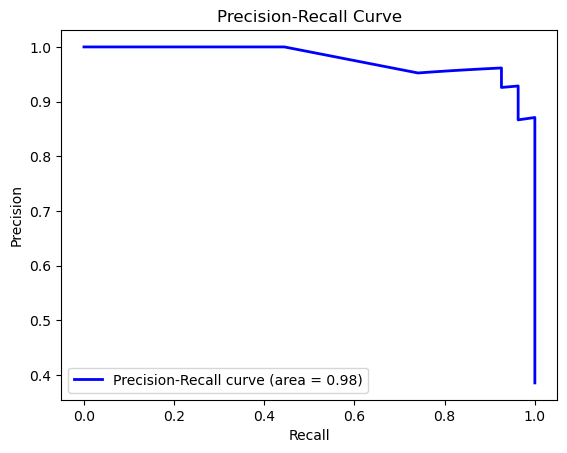

Epoch 1/15, Loss: 0.4555
Epoch 2/15, Loss: 0.0958
Epoch 3/15, Loss: 0.1139
Epoch 4/15, Loss: 0.0720
Epoch 5/15, Loss: 0.0481
Epoch 6/15, Loss: 0.0419
Epoch 7/15, Loss: 0.0434
Epoch 8/15, Loss: 0.0353
Epoch 9/15, Loss: 0.0433
Epoch 10/15, Loss: 0.0409
Epoch 11/15, Loss: 0.0428
Epoch 12/15, Loss: 0.0402
Epoch 13/15, Loss: 0.0968
Epoch 14/15, Loss: 0.0462
Epoch 15/15, Loss: 0.0408
The model's accuracy on the testing dataset is: 0.8. 
 The model's performance report on the testing dataset is the following :
               precision    recall  f1-score   support

           0       0.71      0.94      0.81        32
           1       0.93      0.68      0.79        38

    accuracy                           0.80        70
   macro avg       0.82      0.81      0.80        70
weighted avg       0.83      0.80      0.80        70

Find bellow the Precision-Recall Curve


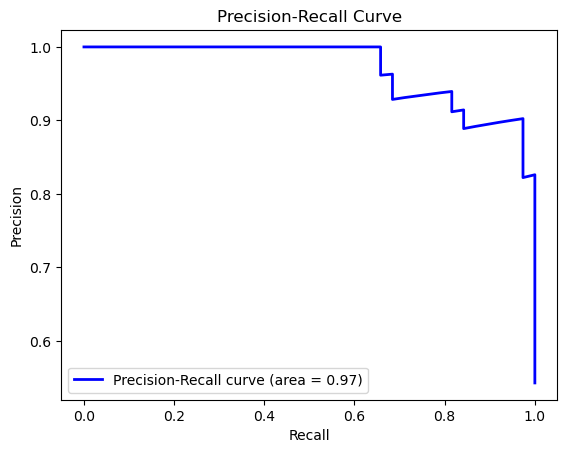

Epoch 1/15, Loss: 0.4622
Epoch 2/15, Loss: 0.1416
Epoch 3/15, Loss: 0.0970
Epoch 4/15, Loss: 0.0843
Epoch 5/15, Loss: 0.0594
Epoch 6/15, Loss: 0.0487
Epoch 7/15, Loss: 0.0457
Epoch 8/15, Loss: 0.0405
Epoch 9/15, Loss: 0.0370
Epoch 10/15, Loss: 0.0393
Epoch 11/15, Loss: 0.0376
Epoch 12/15, Loss: 0.0448
Epoch 13/15, Loss: 0.0433
Epoch 14/15, Loss: 0.0548
Epoch 15/15, Loss: 0.0696
The model's accuracy on the testing dataset is: 0.9. 
 The model's performance report on the testing dataset is the following :
               precision    recall  f1-score   support

           0       0.88      0.95      0.92        40
           1       0.93      0.83      0.88        30

    accuracy                           0.90        70
   macro avg       0.90      0.89      0.90        70
weighted avg       0.90      0.90      0.90        70

Find bellow the Precision-Recall Curve


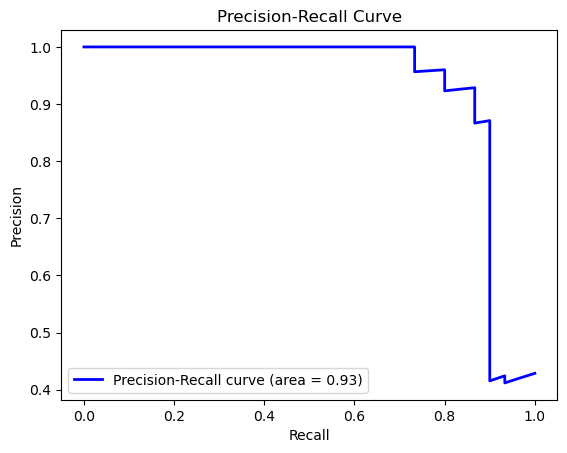

In [ ]:
# J'essaie d'évaluer la stabilité de mon modèle.
acc=[]
recall_acc=[]
for k in range(10):
    train_texts, test_texts, train_labels,test_labels = train_test_split(texts, labels, test_size=0.3)
    label_map = {'homme': 0, 'femme': 1}  
    train_labels = [label_map[label] for label in train_labels]
    test_labels = [label_map[label] for label in test_labels]
    train_dataset = IMDbDataset(train_texts, train_labels, tokenizer, max_length=128)
    test_dataset = IMDbDataset(test_texts, test_labels, tokenizer, max_length=128)
    classifier = GenderClassifier()
    classifier.train(train_dataset,num_epochs=15)  
    classifier.evaluate(test_dataset,conf_matrix=False,Roc_curve=False,pr_curve=True)
    acc.append(classifier.accuracy)
    recall_acc.append(classifier.recall_acc)

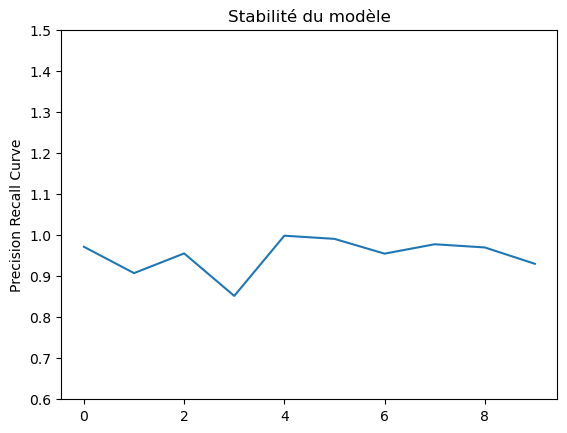

In [27]:
plt.plot(recall_acc)
plt.ylim(0.6, 1.5)
plt.title('Stabilité du modèle')
plt.ylabel('Precision Recall Curve')
plt.show()

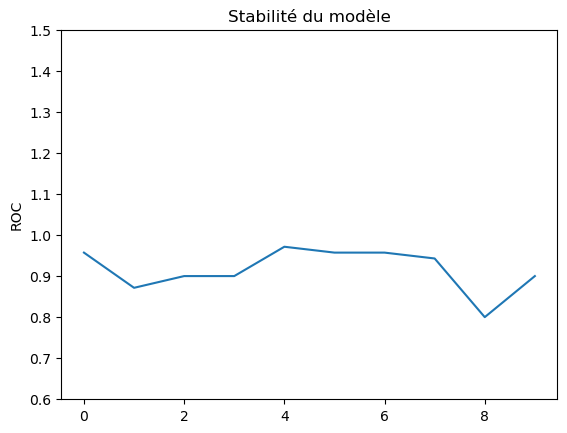

In [28]:
plt.plot(acc)
plt.ylim(0.6, 1.5)
plt.title('Stabilité du modèle')
plt.ylabel('ROC')
plt.show()